# The numbers behind Formula One champions

On this notebook, I will analise several statistics of Formula One's most succesfull drivers. The covered topics will be:
* The top 10 drivers with the most wins
* How the definition of a successfull driver changed over the years
* The influence the team has over a driver's success
* Interesting bits of data

For this analysis, I will be using ergast's database. More info about it can be found at http://ergast.com/mrd/

In [2]:
# Standart imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import requests


Bad key "text.kerning_factor" on line 4 in
C:\Users\Leonardo\Documents\Python\Research-Projects\research-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Top 10 best drivers

In this section, we analyze the 10 drivers who won the most.

First, let's use the api to see which seasons it has data of.

In [3]:
response = requests.get(url="http://ergast.com/api/f1/seasons.json?limit=73&offset=0")
data = response.json()
list_of_seasons = []
for season in data["MRData"]["SeasonTable"]["Seasons"]:
    list_of_seasons.append(season["season"])
print(len(list_of_seasons))

73


F1's first season was back in 1950. So the database used has all seasons logged.

Now, let's see an example of how to get all the winners of a season, and then graph it.

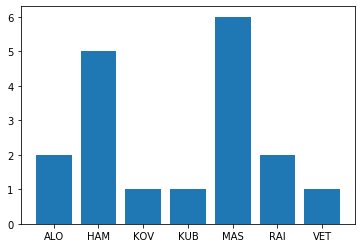

In [4]:
response = requests.get(url="http://ergast.com/api/f1/2008/results/1.json")
data = response.json()
winners_2008 = []
for race in data["MRData"]["RaceTable"]["Races"]:
    winners_2008.append(race["Results"][0]["Driver"]["code"])

drivers, nmbr_wins = np.unique(winners_2008, return_counts=True)
plt.bar(x=drivers, height=nmbr_wins, align="center");

So we see that Felipe Massa won one more race than Lewis Hamilton, but still lost the 2008 championship.

Now, let's try to do the same, but for every season in Formula 1.

In [5]:
year = 1950
winners_list = []
winners_dict = {}
for i in range(73):
    response = requests.get(url=f"http://ergast.com/api/f1/{year+i}/results/1.json")
    data = response.json()
    for race in data["MRData"]["RaceTable"]["Races"]:
        # Every time a driver wins, let's append his name to winners_list
        winners_list.append(race["Results"][0]["Driver"]["givenName"]+" "+race["Results"][0]["Driver"]["familyName"])
for driver in winners_list:
    # Each key on winners_dict will have a value of how many times that driver appears on winners_list
    winners_dict[driver] = winners_list.count(driver)
winners_dict

{'Nino Farina': 5,
 'Juan Fangio': 23,
 'Johnnie Parsons': 1,
 'Lee Wallard': 1,
 'José Froilán González': 2,
 'Alberto Ascari': 13,
 'Piero Taruffi': 1,
 'Troy Ruttman': 1,
 'Bill Vukovich': 2,
 'Mike Hawthorn': 3,
 'Maurice Trintignant': 2,
 'Bob Sweikert': 1,
 'Stirling Moss': 16,
 'Luigi Musso': 1,
 'Pat Flaherty': 1,
 'Peter Collins': 3,
 'Sam Hanks': 1,
 'Jimmy Bryan': 1,
 'Tony Brooks': 5,
 'Jack Brabham': 14,
 'Rodger Ward': 1,
 'Jo Bonnier': 1,
 'Bruce McLaren': 4,
 'Jim Rathmann': 1,
 'Phil Hill': 3,
 'Wolfgang von Trips': 2,
 'Giancarlo Baghetti': 1,
 'Innes Ireland': 1,
 'Graham Hill': 14,
 'Jim Clark': 25,
 'Dan Gurney': 4,
 'John Surtees': 6,
 'Lorenzo Bandini': 1,
 'Jackie Stewart': 27,
 'Richie Ginther': 1,
 'Ludovico Scarfiotti': 1,
 'Pedro Rodríguez': 2,
 'Denny Hulme': 8,
 'Jacky Ickx': 8,
 'Jo Siffert': 2,
 'Jochen Rindt': 6,
 'Clay Regazzoni': 5,
 'Emerson Fittipaldi': 14,
 'Mario Andretti': 12,
 'Peter Gethin': 1,
 'François Cevert': 1,
 'Jean-Pierre Beltoise': 1,

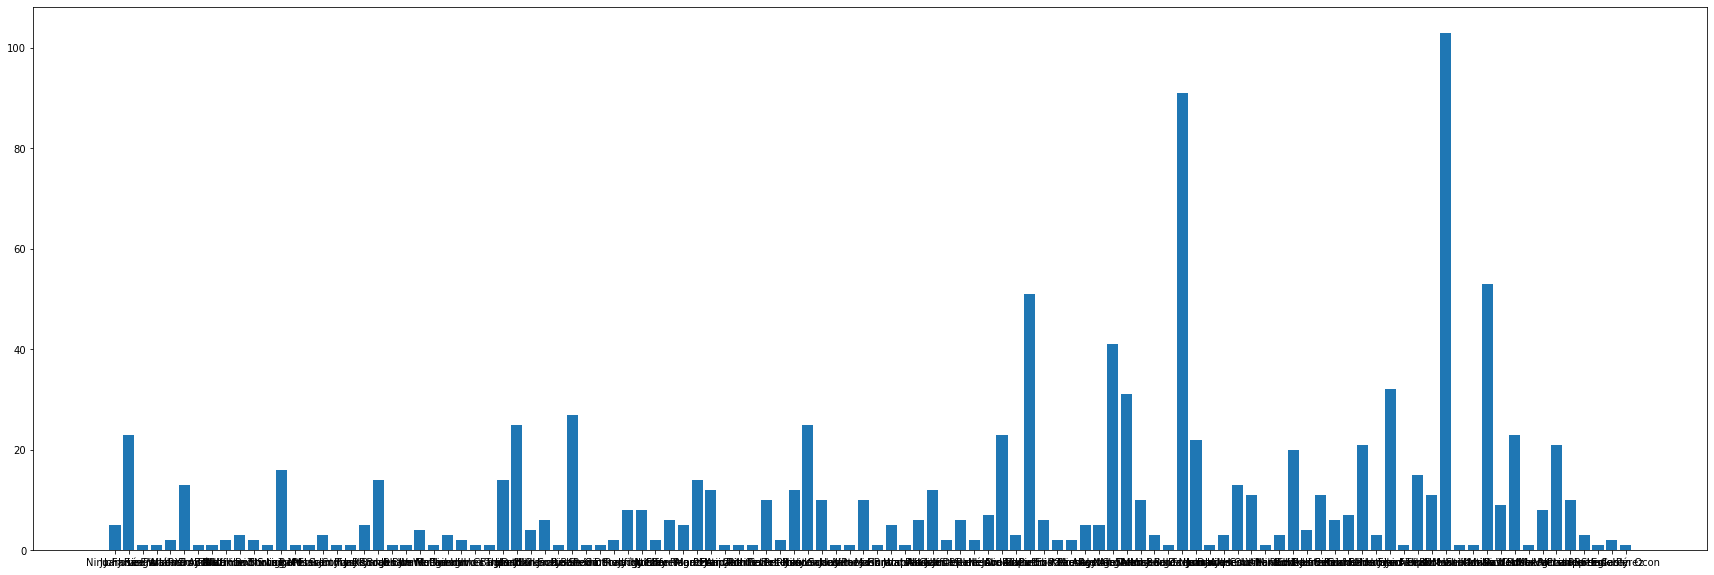

In [6]:
plt.subplots(figsize=(30,10))
plt.bar(x=winners_dict.keys(), height=winners_dict.values(), align="center");

In [7]:
# Making a DataFrame to make things clearer
driver_series = pd.Series(winners_dict.keys())
wins_series = pd.Series(winners_dict.values())
test = {
    "Drivers":driver_series,
    "Wins":wins_series
}
wincount_df = pd.DataFrame(test)
wincount_df

,Drivers,Wins
0,Nino Farina,5
1,Juan Fangio,23
2,Johnnie Parsons,1
3,Lee Wallard,1
4,José Froilán González,2
...,...,...
105,Valtteri Bottas,10
106,Charles Leclerc,3
107,Pierre Gasly,1
108,Sergio Pérez,2


In [8]:
# Now let's see the top 10 winners.
sorted_wincount_df = wincount_df.sort_values("Wins", ascending=False, axis=0)
top_10_df = sorted_wincount_df[:10]
top_10_df

,Drivers,Wins
96,Lewis Hamilton,103
77,Michael Schumacher,91
99,Sebastian Vettel,53
66,Alain Prost,51
72,Ayrton Senna,41
92,Fernando Alonso,32
73,Nigel Mansell,31
33,Jackie Stewart,27
29,Jim Clark,25
50,Niki Lauda,25


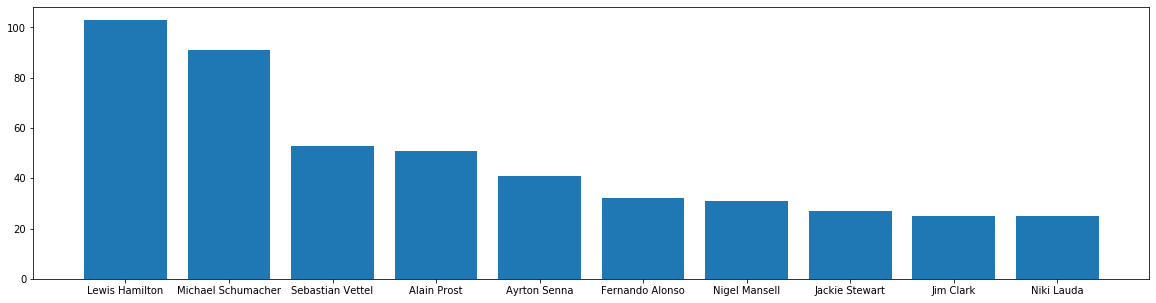

In [9]:
# Making a graph of these guys
plt.subplots(figsize=(20,5))
plt.bar(x=top_10_df.Drivers, height=top_10_df.Wins);

This graph shows us the 10 drivers who won the most races. With only this info at hand, one might say that these are the best drivers Formula 1 has ever had.

But this misses a critical point: How the sport changed over the years.

## How the definition of a succesfull driver changed over the years

To have a better understanding of how dominant a driver was, we need to consider the state of the sport back when they were driving.

### Races per season

This is probably the most important factor. Lewis Hamilton and Michael Schumacher would probably have a much harder time getting 90~100 race wins back in 1980, as back then there were only 14 races per season.

With this in mind, let's see how the number of races per season has changed over the years.

In [10]:
year = 1950
# Let's use a dictionary to store this data
races_per_season = {}
# This time we don't want to include the 2022 season, as it is not over. So, range(72).
for i in range(72):
    response = requests.get(url=f"http://ergast.com/api/f1/{year+i}/results/1.json")
    data = response.json()
    races_per_season[year+i] = 0
    for race in data["MRData"]["RaceTable"]["Races"]:
        races_per_season[year+i] += 1

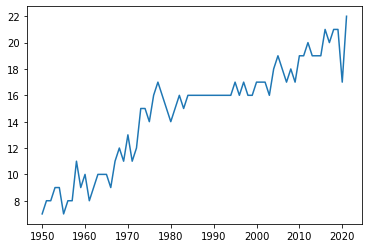

In [11]:
plt.plot(list(races_per_season.keys()), list(races_per_season.values()));

Notice the upward trend. In the first decades, there were barely 10 races a year. If Hamilton was to get his 100 wins back then, he would need to win a decade's worth of championships first. This would be extremely unlikely, since the car regulations change after every season, and a team that has a good car for one year might not have one for the next.

This is why well-known drivers such as Juan Fangio or Alberto Ascari are not in the top 10: They simply did not have enough races per season to do so. Furthermore, the regulation changes after each year were massive, since the engineers were still discovering the importance of downforce, and different ways of achieving it. As a result, it was unusual for a team to do well for more than a couple of years. This makes it even more impressive when someone who raced in those early years, such as Niki Lauda or Jim Clark, does appear in the top 10.

Sidenote: Notice how covid-19 impacted the graph during the 2020 season: We went back to having as many races as we had back in the late 2000s.

### Average driver age throughout the years

It is important to analyze this data, as every sporstsmen has an "expiration date"; when their bodies simply aren't up to the task anymore. Which means that the earlier someone starts at F1, the more races they can have before retiring. 

This wasn't really a concern back in the 50s, as the sport was still growing, and every driver was old enough to be a dad. Nowadays, the 2021 champion started on F1 when he was just 17 years old. And he started go-karting when he was just 4 years old.

To analyze this data, we will analyze two averages: The average of the whole grid, and the average of the championship winner.

To prevent the code from running for 3 minutes, we will not analyze the age of all drivers in all the races of a season. Instead, we will only look at the first race of the season, and draw our year-average from there.

In [12]:
year = 1950
# Let's store the data on a list
driver_avg_age = {}
# Again, we don't include the 2022 season, as the Monaco GP hasn't happened yet. So, range(72).
for i in range(73):
    # We now need the 1 after the year to specify which race we want
    response = requests.get(url=f"http://ergast.com/api/f1/{year+i}/1/results.json")
    data = response.json()
    year_average = 0
    total_drivers = 0
    sum_of_age = 0
    for driver in data["MRData"]["RaceTable"]["Races"][0]["Results"]:
        # Get the year they were born, and subtract to find how old they were
        sum_of_age += (year+i) - int(driver["Driver"]["dateOfBirth"][:4])
        total_drivers += 1
    year_average = sum_of_age/total_drivers
    driver_avg_age[year+i] = year_average
driver_avg_age

{1950: 39.52173913043478,
 1951: 39.76190476190476,
 1952: 37.31818181818182,
 1953: 35.588235294117645,
 1954: 36.388888888888886,
 1955: 34.8,
 1956: 34.6875,
 1957: 32.1764705882353,
 1958: 36.1,
 1959: 32.416666666666664,
 1960: 33.26086956521739,
 1961: 30.904761904761905,
 1962: 30.59090909090909,
 1963: 31.28,
 1964: 31.869565217391305,
 1965: 31.433333333333334,
 1966: 32.25,
 1967: 33.72222222222222,
 1968: 33.0,
 1969: 33.166666666666664,
 1970: 31.82608695652174,
 1971: 32.76,
 1972: 31.136363636363637,
 1973: 31.05263157894737,
 1974: 30.96,
 1975: 31.608695652173914,
 1976: 30.772727272727273,
 1977: 31.476190476190474,
 1978: 31.22222222222222,
 1979: 31.0,
 1980: 30.892857142857142,
 1981: 29.413793103448278,
 1982: 30.166666666666668,
 1983: 30.107142857142858,
 1984: 30.14814814814815,
 1985: 30.8,
 1986: 31.76,
 1987: 29.82608695652174,
 1988: 30.533333333333335,
 1989: 30.733333333333334,
 1990: 30.4,
 1991: 30.433333333333334,
 1992: 30.0,
 1993: 30.653846153846153,

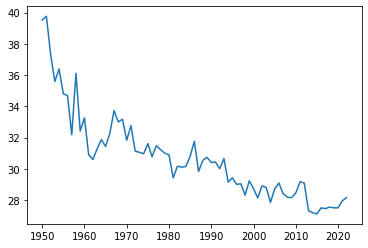

In [13]:
# Make the data more visual
plt.plot(list(driver_avg_age.keys()), list(driver_avg_age.values()));

The average difference between a current F1 driver and one from 1960s is around 5 years. Of course there are outliers, such as Lewis Hamilton winning his 100th GP at the "old" age of 36. But the trend is clear: the drivers are getting younger, and as a result they have more time to break records.

## Team's influence over a driver success

Perhaps the most important factor of all: the driver's team. They are the ones responsible  behind the car that each world champion used to win. No one in the history of F1 managed to win a championship with a below average car.

The tricky part is: how can you say that a driver's win was because of the car, not because of skill? 

The answer is that you can't really do that. Many factors need to be taken into consideration when deciding if a car is good or not; you would need to have a team of engineers analyzing each car's blueprints to arrive at an educated conclusion. Add to that the amount of seasons we had, and accurately analyzing if a driver's success was down to skill or engineering is basically impossible.

With that said, we can make some guesses.

The main point we are going to analyze is the other championship that happens in F1: the World Constructors' Championship. While the World Driver's Championship mostly comes down to one driver only, the constructors' relies on the teammate as well. If a team has one good driver and a bad driver, they might win the WDC, but they will most likely lose the WCC. They need both drivers scoring points throughout the season to get the WCC.

For the following data analysis, we will assume that it's unlikely for a team to have 2 extremely good drivers. This means that, if a team won the WCC, it was because they just had the better car all around. So if the team managed to win just the WDC, but not the WCC, it is an indicator that driver's skill played a role on the championship result.

Of course this is prone to errors. For instance: for a couple of seasons McLaren had both Ayrton Senna and Alain Prost as their drivers, and both of them are in the top 10 wins list and are in the discussion of being the greatest of all time. During those years, they also constructed what turned out to be the most dominant car of all time: the MP4/4, winning 15 out of the 16 races of 1988. This would lead us to believe that the 1988 WDC was decided at the factory, and that Senna (who won the WDC that year) wasn't necessarily good. But then again, scenarios like this almost never happened again.

In [38]:
year = 1950
# Let's use a dictionary to store this data
is_wdc_also_wcc = {}
# The constructors championship was not awarded until 1958. So the first year needs to be 1958
year=1958
# This time, we need to adjust our range.
for i in range(65):
    drivers_response = requests.get(url=f"http://ergast.com/api/f1/{year+i}/driverStandings.json")
    teams_response = requests.get(url=f"http://ergast.com/api/f1/{year+i}/constructorStandings.json")
    drivers_data = drivers_response.json()
    teams_data = teams_response.json()
    # The team who won the wdc
    wdc_winner = drivers_data["MRData"]["StandingsTable"]["StandingsLists"][0]["DriverStandings"][0]["Constructors"][0]["constructorId"]
    # The team who won the wcc
    wcc_winner = teams_data["MRData"]["StandingsTable"]["StandingsLists"][0]["ConstructorStandings"][0]["Constructor"]["constructorId"]
    if wdc_winner == wcc_winner:
        is_wdc_also_wcc[year+i] = 1
    else:
        is_wdc_also_wcc[year+i] = 0

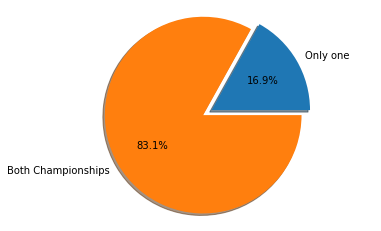

In [54]:
wdc_is_wcc_percent = np.average(list(is_wdc_also_wcc.values()))
explode = (0,0.1)
labels = ["Only one","Both Championships"]
fig, ax1 = plt.subplots()
ax1.pie([1-wdc_is_wcc_percent,wdc_is_wcc_percent],explode=explode,labels=labels,autopct='%1.1f%%',shadow=True);
ax1.axis("equal");

This graph shows us the expected: Most of the times, if a driver wins the wdc, the team wins the wcc too.

This means that, in order to win, a driver must have an atleast somewhat competitive car.